In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Load Fitted Parameters

In [2]:
ticker = "SPY"

log_returns = pd.read_csv("../data/interim/log_returns.csv", index_col=0)
params = pd.read_csv(f"../data/interim/{ticker}_fitted_distributions.csv")

params

,Distribution,Param_1,Param_2,Param_3
0,Normal,0.000504,0.010921,NaN
1,Student-t,2.680562,0.000943,0.006222
2,Skew-Normal,-1.097562,0.008291,0.013411


# Extract Parameters

In [3]:
# Normal
mu_norm = params.loc[params["Distribution"] == "Normal", "Param_1"].values[0]
sigma_norm = params.loc[params["Distribution"] == "Normal", "Param_2"].values[0]

# Student-t
nu_t = params.loc[params["Distribution"] == "Student-t", "Param_1"].values[0]
mu_t = params.loc[params["Distribution"] == "Student-t", "Param_2"].values[0]
sigma_t = params.loc[params["Distribution"] == "Student-t", "Param_3"].values[0]

# Skew-Normal
alpha_skew = params.loc[params["Distribution"] == "Skew-Normal", "Param_1"].values[0]
mu_skew = params.loc[params["Distribution"] == "Skew-Normal", "Param_2"].values[0]
sigma_skew = params.loc[params["Distribution"] == "Skew-Normal", "Param_3"].values[0]

# Simulation Settings

In [4]:
n_simulations = 10000
horizon_days = 1   # 1-day VaR
initial_price = 100

# Generate Simulated Returns

In [5]:
# Normal
sim_norm = stats.norm.rvs(mu_norm, sigma_norm, size=n_simulations)

# Student-t
sim_t = stats.t.rvs(nu_t, loc=mu_t, scale=sigma_t, size=n_simulations)

# Skew-Normal
sim_skew = stats.skewnorm.rvs(alpha_skew, loc=mu_skew,
                              scale=sigma_skew,
                              size=n_simulations)

# Convert Returns to Future Prices

In [6]:
price_norm = initial_price * np.exp(sim_norm)
price_t = initial_price * np.exp(sim_t)
price_skew = initial_price * np.exp(sim_skew)

# Compute Loss Distribution

In [7]:
loss_norm = initial_price - price_norm
loss_t = initial_price - price_t
loss_skew = initial_price - price_skew

# VaR Function

In [8]:
def compute_var(losses, alpha=0.95):
    return np.quantile(losses, alpha)

def compute_es(losses, alpha=0.95):
    var = compute_var(losses, alpha)
    return losses[losses >= var].mean()

# Compute VaR and ES

In [9]:
results = []

for name, losses in zip(
    ["Normal", "Student-t", "Skew-Normal"],
    [loss_norm, loss_t, loss_skew]
):
    var_95 = compute_var(losses, 0.95)
    es_95 = compute_es(losses, 0.95)

    var_99 = compute_var(losses, 0.99)
    es_99 = compute_es(losses, 0.99)

    results.append([name, var_95, es_95, var_99, es_99])

risk_table = pd.DataFrame(
    results,
    columns=["Distribution", "VaR_95", "ES_95", "VaR_99", "ES_99"]
)

risk_table

,Distribution,VaR_95,ES_95,VaR_99,ES_99
0,Normal,1.706875,2.143237,2.445230,2.796633
1,Student-t,1.451358,2.606701,3.059644,5.084389
2,Skew-Normal,1.784251,2.304236,2.608181,3.014602


# Plot Loss Distribution

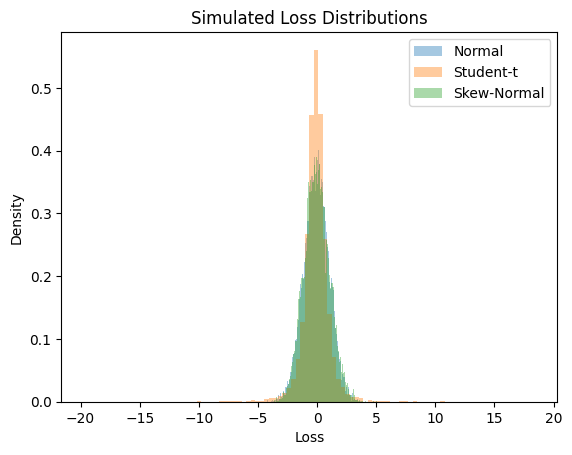

In [10]:
plt.hist(loss_norm, bins=100, density=True, alpha=0.4, label="Normal")
plt.hist(loss_t, bins=100, density=True, alpha=0.4, label="Student-t")
plt.hist(loss_skew, bins=100, density=True, alpha=0.4, label="Skew-Normal")

plt.title("Simulated Loss Distributions")
plt.xlabel("Loss")
plt.ylabel("Density")
plt.legend()
plt.show()